# Identifying High Closing Price

# Imports 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np

import yfinance as yf
import datetime as dt
from datetime import date
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score

from scipy.signal import savgol_filter, argrelmin, argrelmax 

import warnings
warnings.filterwarnings("ignore")

# Bitcoin Dataset from Yahoo Finance

In [2]:
# Here we create the present date as the end date for our yahoo finance end day.
today = date.today().strftime('%Y-%m-%d')
today

'2020-08-30'

In [3]:
# We will grab our data from Yahoo Finance
# We have to set a start date for the first initial data and th end date.
data = yf.Ticker('BTC-USD')
bit_data = data.history(start='2017-01-01',end=today)

In [4]:
bitcoin = bit_data

In [5]:
bitcoin.shape

(1337, 7)

In [6]:
bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,147775008,0,0
2017-01-02,998.62,1031.39,996.70,1021.75,222184992,0,0
2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000,0,0
2017-01-04,1044.40,1159.42,1044.40,1154.73,344945984,0,0
2017-01-05,1156.73,1191.10,910.42,1013.38,510199008,0,0


In [7]:
bitcoin.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-01,963.66,1003.08,958.70,998.33,147775008,0,0
2017-01-02,998.62,1031.39,996.70,1021.75,222184992,0,0
2017-01-03,1021.60,1044.08,1021.60,1043.84,185168000,0,0
2017-01-04,1044.40,1159.42,1044.40,1154.73,344945984,0,0
2017-01-05,1156.73,1191.10,910.42,1013.38,510199008,0,0


In [8]:
# Dropping 'Dividends' , 'Stock Splits' because they contain NO data.
bitcoin.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

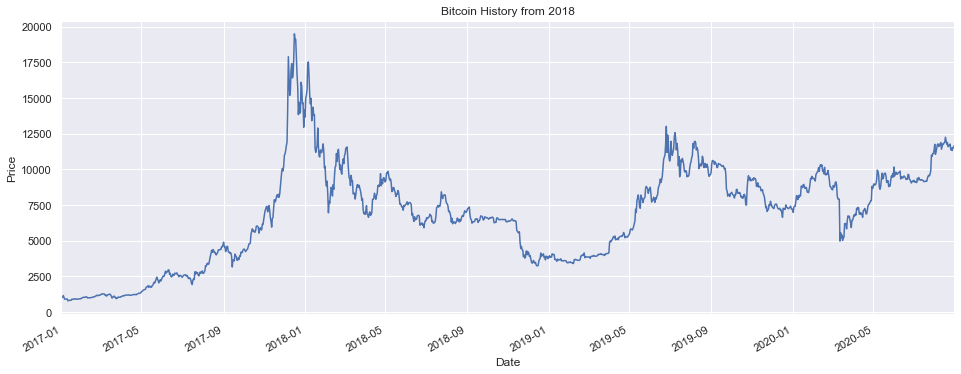

In [9]:
# Lets see our data
plt.figure(figsize=(16,6))
bitcoin.Close.plot()
plt.title('Bitcoin History from 2018')
plt.ylabel('Price');

## Smooth out the data and remove noise

### **savgol_filter**
- will smooth out our data points and make the graph less volatile.

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html

In [10]:
# We create a new columns and start with with a 0 int. 
# savgol_filter will smooth out the data 
# polyorder(int) will be how smooth you want the data. (lower = more smooth)/(high = less smooth)
# Window will be the length we want to filter (must be odd int.)
window = 9
bitcoin['smooth'] = savgol_filter(bitcoin.Close, window, polyorder=6)

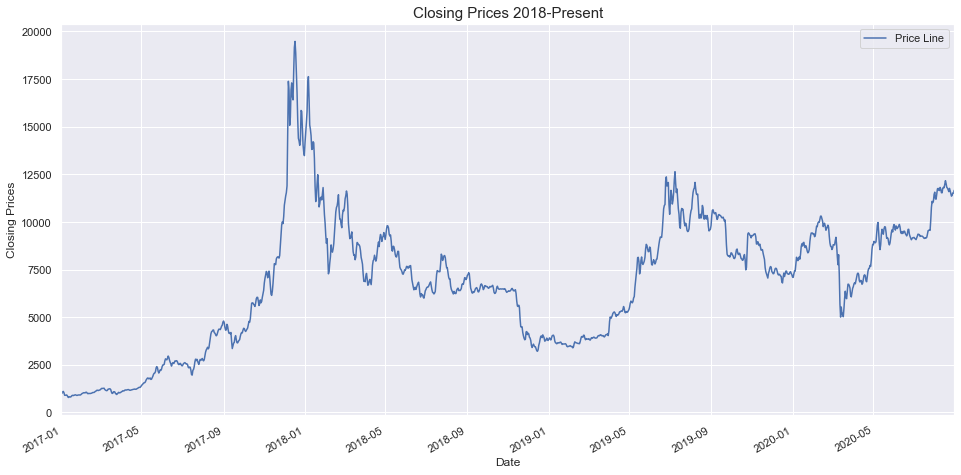

In [11]:
# less sharpness of points and visually less volatile than their original values
plt.figure(figsize=(16,8))
# bitcoin.Close.plot()
bitcoin.smooth.plot(label='Price Line')
plt.ylabel('Closing Prices')
plt.title('Closing Prices 2018-Present', fontsize=15)
plt.legend();
# plt.savefig('bitcoin_graph', transparent =True);

In [12]:
# Here we can see that the smooth column is a bit off compared to the Close column. 
# Smooth column represents Close price, but smoother or a bit less stiff
bitcoin.tail(15)

,Open,High,Low,Close,Volume,smooth
Date,,,,,,
2020-08-16,11866.69,11934.90,11737.19,11892.80,20583375490,11989.738632
2020-08-17,11895.66,12359.06,11806.70,12254.40,28227687027,12167.525649
2020-08-18,12251.90,12335.71,11954.53,11991.23,26043227672,12012.692533
2020-08-19,11990.88,12028.92,11687.33,11758.28,24502851117,11817.954429
2020-08-20,11761.50,11900.41,11710.06,11878.37,20175242945,11775.018780
2020-08-21,11878.03,11899.26,11564.98,11592.49,23762425999,11693.412758
2020-08-22,11585.48,11689.41,11448.81,11681.83,20224191306,11594.346154
2020-08-23,11679.70,11713.43,11559.92,11664.85,18482062658,11762.922774
2020-08-24,11663.69,11807.63,11623.25,11774.60,20681511755,11647.619946


### argrelmin
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmin.html
### argrelmax
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmax.html#scipy.signal.argrelmax

- argrelmin/max: will find the minima/maxima 
- order is the amount of data points to the left and right. (the amount of adjacent points)

In [13]:
# we will create a new column in the dataframe and set all values to 0
# order: amount of array in which to find the relative minima
# selecting the [0], turns type numpy.ndarray(tuple does not have .tolist meth.). Turn to list type

min_ids = 'min_ids'
max_ids = 'max_ids'
bitcoin[max_ids] = 0
bitcoin[min_ids] = 0

min_id = argrelmin(bitcoin.smooth.values, order=50)[0].tolist()
max_id = argrelmax(bitcoin.smooth.values, order=50)[0].tolist()

# .iloc the min/max and turn them to 1, to indicate if they are low/high price point
# all other data will be 0 if they are not low/high indicators 
bitcoin[min_ids].iloc[min_id] = 1
bitcoin[max_ids].iloc[max_id] = 1

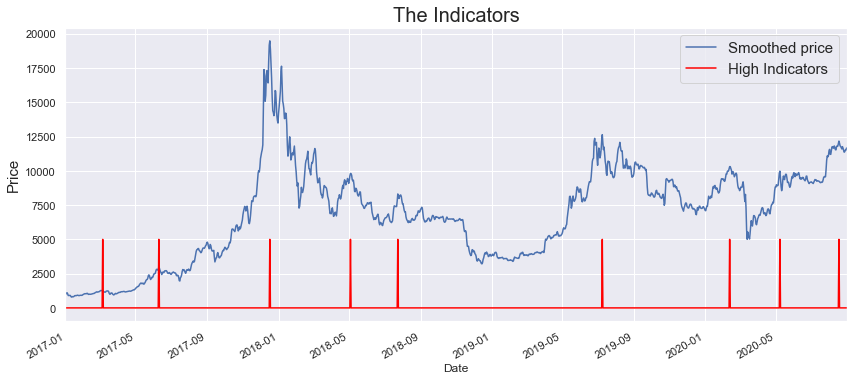

In [14]:
plt.figure(figsize=(14,6))
bitcoin.smooth.plot(label='Smoothed price')
(5000*bitcoin.max_ids).plot(color='red', label='High Indicators')
plt.title('The Indicators', fontsize=20)
plt.ylabel('Price', fontsize=15)
plt.legend(fontsize=15);

# Baseline Model
## LogisticRegression Model: target: max_ids (High Close Price) Best Buy Price

In [15]:
# We created a seperate list for the features dropping ['Open', 'Close', 'Low', 'High', 'min_ids']
# Keeping them may result in multicolinearity.
features_list = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids']).columns.tolist()

In [16]:
# These are the features we will be using
features_list

['Volume', 'smooth', 'min_ids']

In [17]:
# Lets drop all NaNs and give it a new var. 
# X(features): the clean_bit dataset with the features_list
# y(target): this is our target min_ids (the low closing values)
X = bitcoin[features_list]
y = bitcoin['max_ids']

In [18]:
bitcoin['max_ids'].value_counts()

0    1328
1       9
Name: max_ids, dtype: int64

In [19]:
# Lets scale our data so everything is on the same playing field
# We call our LogisticRegression model and give it a var. to call on it later
# We then create a pipe for the scaler and logreg
scaler = preprocessing.StandardScaler().fit(X)
LogReg = LogisticRegression(class_weight='balanced', random_state=42)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
scores.mean(), scores.std()

(0.7940512048192772, 0.1246837658642746)

In [20]:
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
scores.mean(), scores.std()

(0.5696152471177048, 0.35487076380009946)

### Initial baseline test
- Baseline model has a 64% accuracy, Horrible!

----------------------------------------------------------------------------------------------------------

# Feature Engineering

- MACD: Moving Average Convergence Divergence
    - Subtracts the 26-period Expoential Moving Average(EMA) from the 12-period (EMA). 
    - https://www.investopedia.com/terms/m/macd.asp
- Std: of rolling (n)windows
    - this will give us a standard deviation of (n)windows from the mean.
- RSI: Relative Strength Index
    - this is a momentum indicator.
    - the standard period is 14(days)
    - calulates the average gain and lose for a period of time
    - values 0 - 100
    - https://www.investopedia.com/terms/r/rsi.asp
- EWM: Exponential Weighted function
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [21]:
# the window we will use is a 5 and 10 day window
# we will find the avg. of these windows and subtract 
windows = [5, 10]

for w in windows:
    rm = bitcoin.Close.rolling(w).mean()
    bitcoin['MACD_'+str(w)] = rm - bitcoin.Close
    bitcoin['Std_'+str(w)] = bitcoin.Close.rolling(w).std()    
    
    
# the rsi_period will be our standard 14 day window
# Out of the 14 day period. We want to know what are the gains and losses
# 1. we will need to know the diff(1) of two diff. days periodically. 
# 2. we use mask to hide any data that is not a gain 
    # - this will hide the losses and 0 changes.
# 3. this is the same for our loss, hide anything that is not a loss

rsi_period = 14
change = bitcoin.Close.diff(1)
gain = change.mask(change<0,0)
loss = change.mask(change>0,0)

# here we use EWM to find the gain/loss with a period of time
# min_periods: will be our standard 14 day period
# com: is the period that we want to weight in
    # - we want to use the 14 day period, but compare the avg. gain/loss to the original close price
    # - hence why we subtract 1, taking the initial closing price out of the equation since we are
    # using it as a comparison
# we will do this for the gain and loss averages.
avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()

# here we find the absolute value of the relative strength for the gain and loss
rs = abs(avg_gain/avg_loss)

# this is the equation/math for RSI
# we will subtract it from 100 since the scale is 0-100.
rsi = 100 - (100/(1+rs))
bitcoin['RSI'] = rsi

In [22]:
def vwap(bitcoin):
    vol = bitcoin['Volume'].values
    close = bitcoin['Close'].values
    return bitcoin.assign(vwap=(close*vol).cumsum() / vol.cumsum())

In [23]:
bitcoin = bitcoin.groupby(bitcoin.index, group_keys=True).apply(vwap).droplevel(1)

In [24]:
# after finding and creating a new RSI column, we will drop all NANs
clean_bit = bitcoin.dropna()

In [25]:
clean_bit.head()

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids,MACD_5,Std_5,MACD_10,Std_10,RSI,vwap
Date,,,,,,,,,,,,,,
2017-01-15,818.14,823.31,812.87,821.80,71013600,812.181935,0,0,-12.444,19.166907,36.128,52.832737,33.585566,821.80
2017-01-16,821.78,834.53,820.27,831.53,82755200,847.858112,0,0,-11.420,9.805838,19.331,50.945616,35.523319,831.53
2017-01-17,830.95,910.56,830.80,907.94,155095008,888.566208,0,0,-67.208,37.877810,-57.144,50.864127,48.284210,907.94
2017-01-18,909.37,917.50,858.30,886.62,225676992,902.888718,0,0,-33.360,41.168067,-38.282,48.141842,45.573916,886.62
2017-01-19,888.34,904.61,884.34,899.07,105625000,887.712541,0,0,-29.678,39.881278,-51.108,47.681439,47.429664,899.07


### Setting up a binary classifier for RSI

In [26]:
# here we create new columns to help us identify if the RSI is >=70 or <=30
# initially we just want the columns to be all 0, we will change this later
# we call upon the new column and .loc the 'RSI' with a bool statement
# if the statement is True then we will identify it as a 1, if not then it will remain a 0

rsi_70 = 'RSI_70'
rsi_30 = 'RSI_30'
clean_bit[rsi_70] = 0
clean_bit[rsi_30] = 0
clean_bit[rsi_70].loc[bitcoin['RSI'] >=70] = 1
clean_bit[rsi_30].loc[bitcoin['RSI'] <=30] = 1

## Low Close Predictions + New Features

In [27]:
features_list = clean_bit.drop(columns=['Open', 'High', 'Low', 'Close', 'max_ids',]).columns.tolist()
X = clean_bit[features_list]
y = clean_bit['max_ids']

In [28]:
print(X.columns)

Index(['Volume', 'smooth', 'min_ids', 'MACD_5', 'Std_5', 'MACD_10', 'Std_10',
       'RSI', 'vwap', 'RSI_70', 'RSI_30'],
      dtype='object')


In [29]:
# Lets scale our data so everything is on the same playing field
# We call our LogisticRegression model and give it a var. to call on it later
# We then create a pipe for the scaler and logreg
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
print(f'ROC_AUC: {scores.mean(), scores.std()}')

ROC_AUC: (0.9065716355301852, 0.0832830662921929)


In [30]:
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
print(f'Accuracy: {scores.mean(), scores.std()}')

Accuracy: (0.8925661448320059, 0.08315870951668529)


- After feature engineering, our score has improved a lot 
- our model is better at distinguishing a low close price and it's more stable(but NOT perfect)

In [33]:
# now we're gonna see what the model prediction are
high_preds = cross_val_predict(pipe, X, y, n_jobs=-1, cv=4)

In [34]:
# Lets create a dataframe of our predictions and add it to our original clean_bit dataframe
# We can then use this to plot our prediction points
predict_df = pd.DataFrame()
predict_df['high_preds'] = high_preds.tolist()
clean_bit['high_preds'] = predict_df['high_preds'].values

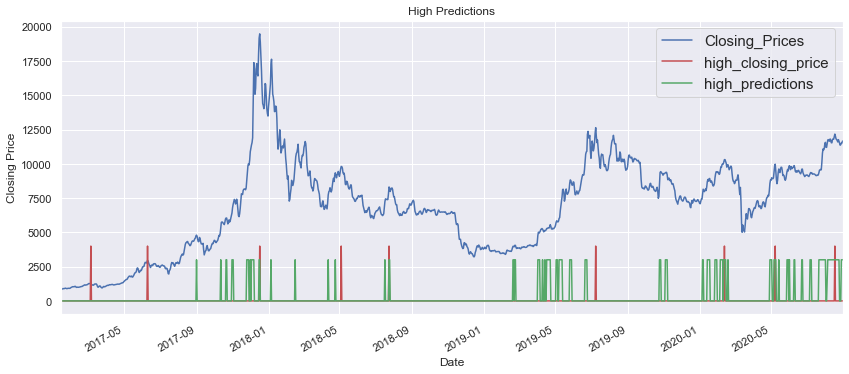

In [35]:
plt.figure(figsize=(14,6))
clean_bit.smooth.plot(label='Closing_Prices')
(4000*clean_bit.max_ids).plot(label='high_closing_price', color='r')
(3000*clean_bit.high_preds).plot(label= 'high_predictions', color='g')
plt.ylabel('Closing Price')
plt.title('High Predictions')
plt.legend(fontsize=15);

- In general, we were able to predict the lows 
- Our model also identified other price points as lows

### RSI Graph

- 70 or higher: overbought or overvalued
- 30 or less: underbought or undervalued
- This graph can show use the flow of the stock's momentum if the value is too high or too low
- RSI can help us predict the possibility of a future drop or a raise.

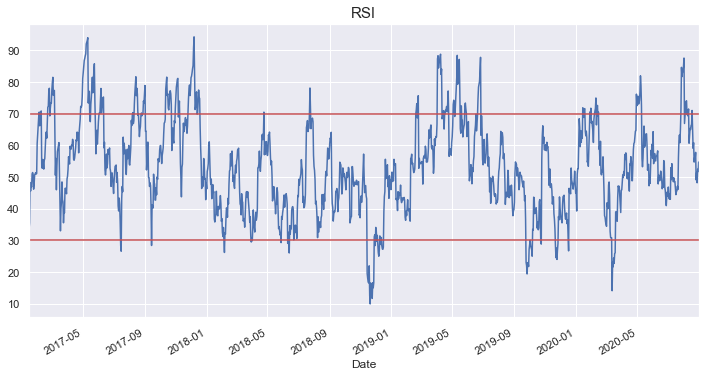

In [36]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,100, step=10))
clean_bit.RSI.plot()
plt.axhline(y=30, color='r')
plt.axhline(y=70, color='r')
plt.title('RSI', fontsize=15);